<a href="https://colab.research.google.com/github/gustavomachin/PythonFinance/blob/master/ValuacionOpcionesKerasYPF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **<font color="DeepPink">Valuación de Opciones Financieras con Keras</font>**

<p align="justify">
Este cuaderno presenta el flujo de trabajo completo diseñado para la valuación de opciones financieras mediante redes neuronales artificiales. La implementación se llevó a cabo en Python, empleando las bibliotecas especializadas en aprendizaje profundo Keras y TensorFlow. Asimismo, se integraron herramientas complementarias como yfinance para la recopilación de datos financieros, pandas para su organización y manipulación, y Scikit-learn para el preprocesamiento y estandarización de las variables explicativas.

 ## **<font color="DeepPink">Importación de bibliotecas y módulos </font>**

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import os
import random
import warnings
warnings.filterwarnings('ignore')

Se importan las bibliotecas y módulos necesarios:

* `yfinance`: Para descargar los datos financieros de Yahoo Finance.

* `pandas`: Para organizar y manipular los datos en tablas (DataFrames). Es la herramienta fundamental para la analítica y ciencia de datos en Python.

* `numpy`: Para realizar cálculos numéricos eficientes, especialmente con arrays.

* `tensorflow` y `keras`: Para construir y entrenar la red neuronal.

* `scikit-learn`: Para tareas de machine learning como dividir los datos (train_test_split), escalarlos (StandardScaler) y calcular las métricas de error (mean_squared_error, etc.).

* `datetime`: Sirve para trabajar con fechas.

* `os`: Permite interactuar con el sistema operativo (crear/eliminar carpetas, manejar rutas, variables de entorno, etc.).

* `random`: Proporciona herramientas para generar números pseudoaleatorios.

 ## **<font color="DeepPink">Establecer la semilla aleatoria para reproducibilidad </font>**

In [2]:
seed_value = 42                                     # Define una variable seed_value y le asigna el número (arbitrario) 42
os.environ['PYTHONHASHSEED'] = str(seed_value)      # Controla la aleatoriedad a nivel de Python para operaciones de hashing.
random.seed(seed_value)                             # Fija la semilla para el generador de números aleatorios del módulo random.
np.random.seed(seed_value)                          # Fija la semilla para el generador de números aleatorios de numpy. scikit-learn usa numpy por debajo.
tf.random.set_seed(seed_value)                      # Fija la semilla para todas las operaciones aleatorias dentro de TensorFlow, como la inicialización de los pesos y sesgos de las neuronas.

<p align="justify">
Esto asegura que los resultados sean los mismos si el script y los datos no cambian.

 ## **<font color="DeepPink">Carga y preparación de los datos (con guardado para reproducibilidad) </font>**

In [3]:
ticker_symbol = "YPF"
csv_filename = "datos_opciones_ypf_completo.csv"

if os.path.exists(csv_filename):                                                # Verifica si un archivo con el nombre contenido en csv_filename ya existe en la carpeta actual.
    print(f"Cargando datos desde el archivo local: {csv_filename}")
    options_df = pd.read_csv(csv_filename)                                      # Lee el contenido del archivo CSV y lo cargar en un DataFrame llamado options_df
else:
    print(f"Descargando datos de yfinance para {ticker_symbol} y guardando en archivo...")
    stock = yf.Ticker(ticker_symbol)                                            # Crea un objeto "Ticker" de yfinance que representa la acción de YPF.
    expirations = stock.options                                                 # El atributo options devuelve una lista con todas las fechas de vencimiento disponibles para las opciones de la acción.

    all_options_list = []                                                       # Crea una lista vacía para ir guardando los DataFrames de cada fecha de vencimiento.

    # Bucle para obtener datos de TODAS las fechas de vencimiento
    for expiration_str in expirations:
        chain = stock.option_chain(expiration_str)                              # Descarga cadena de opciones completa (calls y puts) para esa fecha.
        options = pd.concat([chain.calls, chain.puts], ignore_index=True)       # Une dos DataFrames, chain.calls (las opciones de compra) y chain.puts (las de venta).

        # Calcular días hasta el vencimiento para esta cadena específica
        expiration_date = datetime.datetime.strptime(expiration_str, "%Y-%m-%d")# Convierte la fecha de vencimiento de texto a formato de fecha (datetime).
        today = datetime.datetime.now()
        options["daysToExpiration"] = (expiration_date - today).days            # Crea una nueva columna resultado de restar la fecha de hoy a la de vencimiento, obteniendo el número de días.

        all_options_list.append(options)                                        # Añade el DataFrame options al final de la lista all_options_list

    options_df = pd.concat(all_options_list, ignore_index=True)                 # Une todos los DataFrames que se guardaron en la lista
    options_df.to_csv(csv_filename, index=False)                                # Guarda el contenido del DataFrame options_df en un archivo CSV
    print("Datos guardados exitosamente.")

Descargando datos de yfinance para YPF y guardando en archivo...
Datos guardados exitosamente.


 ## **<font color="DeepPink">Visualización del conjunto de datos </font>**

In [4]:
options_df.shape

(197, 15)

<p align="justify">
El atributo <code>shape</code> de pandas devuelve una tupla con las dimensiones del DataFrame <code>options_df</code>. Esto es fundamental para visualizar rápidamente de la cantidad de datos con las que se trabajará.
<br><br>
193 es el número total de contratos de opciones (<i>calls</i> y <i>puts</i>) recopilados para
YPF a través de todas las fechas de vencimiento. Cada fila es un ejemplo único para entrenar el modelo. Mientras que 15 es el número total de características o variables para cada contrato. Es decir, el conjunto de datos tiene 193 contratos de opciones, y para cada uno 15 variables.

In [5]:
options_df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,daysToExpiration
0,YPF250919C00027000,2025-07-30 14:32:30+00:00,27.0,8.13,3.7,4.00,0.00,0.000000,1.0,1,0.543950,True,REGULAR,USD,20
1,YPF250919C00028000,2025-08-28 17:07:59+00:00,28.0,3.58,2.9,3.10,0.00,0.000000,1.0,90,0.503911,True,REGULAR,USD,20
2,YPF250919C00030000,2025-08-29 14:20:38+00:00,30.0,1.80,1.6,1.75,-0.55,-23.404255,2.0,192,0.507817,True,REGULAR,USD,20
3,YPF250919C00031000,2025-08-29 14:59:58+00:00,31.0,1.25,1.1,1.25,-0.15,-10.714285,13.0,24,0.498540,False,REGULAR,USD,20
4,YPF250919C00032000,2025-08-29 14:31:00+00:00,32.0,0.90,0.7,0.85,-0.18,-16.666674,328.0,623,0.488286,False,REGULAR,USD,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,YPF270115P00045000,2025-01-14 18:50:13+00:00,45.0,10.32,11.0,15.50,0.00,0.000000,1.0,0,0.310310,True,REGULAR,USD,503
193,YPF270115P00050000,2025-01-17 16:44:20+00:00,50.0,14.00,14.9,19.40,0.00,0.000000,20.0,41,0.000010,True,REGULAR,USD,503
194,YPF270115P00055000,2025-04-15 13:30:20+00:00,55.0,23.50,0.0,0.00,0.00,0.000000,NaN,0,0.000010,True,REGULAR,USD,503
195,YPF270115P00060000,2024-12-24 15:09:09+00:00,60.0,21.35,19.8,24.50,0.00,0.000000,10.0,0,0.000010,True,REGULAR,USD,503


In [6]:
options_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     197 non-null    object             
 1   lastTradeDate      197 non-null    datetime64[ns, UTC]
 2   strike             197 non-null    float64            
 3   lastPrice          197 non-null    float64            
 4   bid                197 non-null    float64            
 5   ask                197 non-null    float64            
 6   change             197 non-null    float64            
 7   percentChange      197 non-null    float64            
 8   volume             184 non-null    float64            
 9   openInterest       197 non-null    int64              
 10  impliedVolatility  197 non-null    float64            
 11  inTheMoney         197 non-null    bool               
 12  contractSize       197 non-null    object         

<p align="justify">
El método <code>info()</code> de pandas sirve para obtener un resumen de la estructura del DataFrame: cantidad de filas, columnas, nombre y posición de las variables, cantidad de datos no nulos y tipo de dato.
<br><br>
Las variables del conjunto de datos son:

* `contractSymbol`: identificador único para cada contrato de opción.
* `lastTradeDate`: la fecha y hora exactas de la última vez que se negoció ese contrato.
* `strike`: precio de ejercicio.
* `lastPrice`: último precio al que se ejecutó una transacción para este contrato. Corresponde a la prima y es la variable objetivo ($y$) del modelo.
* `bid`: precio de compra. Es el precio más alto que un comprador está dispuesto a pagar por ese contrato en este momento.
* `ask`: precio de venta. Es el precio más bajo que un vendedor está dispuesto a aceptar por ese contrato en este momento.
* `change`: cambio en el `lastPrice` del contrato en comparación con el precio de cierre del día anterior.
* `percentChange`: cambio porcentual. Brinda la misma información que `change`, pero expresada en términos porcentuales.
* `volume`: volumen negociado. Es el número total de contratos que se han negociado durante el día.
* `openInterest`: interés abierto. Representa el número total de contratos de esa opción que están actualmente "abiertos" o en manos de inversores y que aún no se han cerrado, vencido o ejercido. A diferencia del `volume` (que es diario), `openInterest` es un total acumulado. Representa un indicador de la profundidad del mercado para esa opción.
* `impliedVolatility`: volatilidad implícita. Esta es una de las variables más importantes. No mide la volatilidad pasada de la acción (histórica), sino que es la expectativa del mercado sobre cuán volátil será la acción en el futuro, hasta la fecha de vencimiento.
* `inTheMoney`: indica si la opción tiene valor intrínseco.
  * Para un *call* (opción de compra): está "in the money" si el precio actual de la acción es mayor que el de ejercicio.
  * Para un *put* (opción de venta): está "in the money" si el precio actual de la acción es menor que el de ejercicio.
* `contractSize`: tamaño del contrato. Define cuántas acciones del activo subyacente controla un solo contrato de opción. `REGULAR`: 1 contrato equivale a 100 acciones.
* `currency`: moneda en la que se cotizan los precios de la opción.
* `daysToExpiration`: es una variables creada. Representa el número de días que quedan hasta el vencimiento del contrato.

 ## **<font color="DeepPink">Obtener el precio actual del subyacente para el cálculo de "moneyness"</font>**

In [7]:
stock_info = yf.Ticker(ticker_symbol)
current_stock_price = stock_info.history(period="1d")["Close"].iloc[-1]
current_stock_price

np.float64(30.469999313354492)

<p align="justify">
El método <code>history()</code> de yfinance genera el historial de precios para una periodicidad diaria (<code>period="1d"</code>) del activo financiero. <code>["Close"]</code> selecciona únicamente la columna de precios de cierre, mientras que <code>.iloc[-1]</code> devuelve el último elemento de la columna seleccionada.
<br><br>
Esto permite obtener el precio de cierre más reciente de una acción de YPF (activo subyacente).


 ## **<font color="DeepPink">Eliminar filas con valores nulos en variables críticas</font>**

In [8]:
options_df.dropna(subset=['strike', 'impliedVolatility', 'lastPrice', 'bid', 'ask'], inplace=True)
options_df.shape[0]

197

<p align="justify">
El método <code>dropna()</code> en pandas se usa para eliminar filas (o columnas) que tienen valores nulos (NaN). El parámetro <code>subset</code>, indicá en qué columnas debe fijarse para decidir si elimina la fila.
<br><br>
El nuevo total de filas es 192, lo cual indica que se eliminó 1 sola fila.

 ## **<font color="DeepPink">Ingeniería de variables</font>**

 ### **<font color="DeepPink">Crear la variables "moneyness"</font>**

<p align="justify">
La variable "moneyness" mide qué tan "en el dinero" está una opción. Es una métrica que estandariza la relación entre el precio actual del subyacente ($S$) y el precio de ejercicio de la opción ($E$). Su formula depende del tipo de opción:

* Para `call`:
$$moneyness=\frac{S}{E}$$

* Para `put`:
$$moneyness=\frac{E}{S}$$

<p align="justify">
Un valor de "moneyness" mayor a 1 significa que la opción está "in the money", sin importar si es un <i>call</i> o un <i>put</i>. De manera similar, un valor menor a 1 significa que está "out of the money".


In [9]:
options_df["moneyness"] = np.where(                                             # Aplica un condicional
    options_df["contractSymbol"].str.contains("C"),                             # Revisa la columna contractSymbol para cada fila si el texto contiene la letra "C".
    current_stock_price / options_df["strike"],                                 # Condición verdadera (call): calcula el ratio dividiendo el precio actual de la acción por el precio de ejercicio de la opción.
    options_df["strike"] / current_stock_price                                  # Condición falsa (put): divide el precio de ejercicio por el precio actual de la acción.
    )

<p align="justify">
Revisa si el <code>contractSymbol</code> de cada opción contiene una "C" para determinar si es una opción de compra (<i>call</i>) o de venta (<i>put</i>). Si es un <i>call</i>, calcula el ratio dividiendo el precio actual de la acción por el precio de ejericio; si es un <i>put</i>, aplica la fórmula inversa, dividiendo el precio de ejericio por el precio de la acción.

 ### **<font color="DeepPink">Crear la variables "bid-ask spread"</font>**

<p align="justify">
La diferencia entre <code>bid</code> y <code>ask</code> es el spread, representa una medida de la liquidez del contrato.

In [10]:
options_df['spread'] = options_df['ask'] - options_df['bid']

In [11]:
options_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     197 non-null    object             
 1   lastTradeDate      197 non-null    datetime64[ns, UTC]
 2   strike             197 non-null    float64            
 3   lastPrice          197 non-null    float64            
 4   bid                197 non-null    float64            
 5   ask                197 non-null    float64            
 6   change             197 non-null    float64            
 7   percentChange      197 non-null    float64            
 8   volume             184 non-null    float64            
 9   openInterest       197 non-null    int64              
 10  impliedVolatility  197 non-null    float64            
 11  inTheMoney         197 non-null    bool               
 12  contractSize       197 non-null    object         

 ## **<font color="DeepPink">Definir las variables explicativas y la variable objetivo</font>**

In [12]:
# Se incluyen las "Griegas" y las nuevas variables explicativas.
# Algunas Griegas pueden no estar disponibles, así que seleccionamos las que sí lo estén.
# available_greeks = [col for col in ['delta', 'gamma', 'theta', 'vega', 'rho'] if col in options_df.columns]
features_list = [
    "strike", "impliedVolatility", "volume", "openInterest",
    "bid", "ask", "moneyness", "daysToExpiration", "spread"
] # + available_greeks

In [13]:
print(f"\nVariables explicativas utilizadas para el modelo: {features_list}")


Variables explicativas utilizadas para el modelo: ['strike', 'impliedVolatility', 'volume', 'openInterest', 'bid', 'ask', 'moneyness', 'daysToExpiration', 'spread']


 ## **<font color="DeepPink">Reemplazar valores infinitos y rellenar faltantes</font>**



In [14]:
X_df = options_df[features_list].replace([np.inf, -np.inf], np.nan).fillna(0)
y = options_df["lastPrice"].fillna(0).values

<p align="justify">
Este código busca cualquier valor infinito (positivo o negativo) y lo reemplaza por NaN. Finalmente, el método <code>fillna(0)</code> busca todos los <code>NaN</code> (los que ya existían y los que se acaban de crear) y los rellena con el valor 0. Esta es una estrategia simple de imputación de valores faltantes.

 ## **<font color="DeepPink">Escalado de variables numéricas</font>**

<p align="justify">
El objetivo del escalado de variables es poner todas las variables explicativas en una escala común para que el modelo no se vea sesgado por las diferentes magnitudes de los datos. En especial, los modelos de redes neuronales son muy sensibles a la escala de las variables de entrada.

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

<p align="justify">
Este código primero crea un objeto <code>StandardScaler</code> de scikit-learn y luego, con el método .<code>fit_transform()</code>, realiza dos acciones en un solo paso: primero aprende la media y la desviación estándar de cada columna y, a continuación, transforma cada valor para que todas las variables explicativas queden en la misma escala, con una media de 0 y una desviación estándar de 1.
<br><br>
Este proceso es fundamental para asegurar que las variables con rangos de valores grandes (como el <code>strike</code>) no dominen injustamente el aprendizaje del modelo por encima de variables con rangos pequeños (como la <code>impliedVolatility</code>).
<br><br>
El resultado es almacenado en una matriz de numpy:

In [16]:
X_scaled

array([[-0.42109325, -0.19095078, -0.23536082, ..., -0.03215059,
        -0.87576062, -0.62831191],
       [-0.3448475 , -0.23727816, -0.23536082, ..., -0.06071439,
        -0.87576062, -0.69328695],
       [-0.19235601, -0.23275841, -0.22893358, ..., -0.11212923,
        -0.87576062, -0.72577446],
       ...,
       [ 1.71378759, -0.82032516, -0.24178806, ...,  0.44731343,
         1.9851416 , -0.82323702],
       [ 2.09501631, -0.82032516, -0.1775157 , ...,  0.56360892,
         1.9851416 ,  2.23058973],
       [ 2.47624504, -0.82032516, -0.1775157 , ...,  0.6799044 ,
         1.9851416 ,  2.23058973]])

 ## **<font color="DeepPink">División en conjunto de entrenamiento y prueba</font>**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=seed_value)

<p align="justify">
El método <code>train_test_split()</code> de scikit-learn crea un conjunto de entrenamiento (70%) y otro de prueba (30%).

In [18]:
print(f"\nEl conjunto de entrenamiento representa el {int(round(len(X_train)/len(X_scaled)*100,0))} % del total de datos")


El conjunto de entrenamiento representa el 70 % del total de datos


 ## **<font color="DeepPink">Definir el modelo</font>**

<p align="justify">
<code>Secuential</code> se utiliza para crear modelos de redes neuronales secuenciales en Keras. Un modelo secuencial es simplemente una pila lineal de capas donde la salida de una capa se convierte en la entrada de la siguiente capa. Es adecuado para la mayoría de los modelos simples y es fácil de usar.

In [19]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation="relu"),                  # Primer capa oculta
    Dropout(0.2),                                                               # Primer capa de regularización
    Dense(64, activation="relu"),                                               # Segunda capa oculta
    Dropout(0.15),                                                              # Segunda capa de regularización
    Dense(32, activation="relu"),                                               # Tercer capa oculta
    Dense(1, activation="linear")                                               # Capa de salida
])

<p align="justify">
<b>Primer Capa Oculta</b>: es una capa "densa" o totalmente conectada con 128 neuronas. Una capa densa es una capa en la que cada neurona está conectada a todas las neuronas de la capa anterior, es decir, cada una de estas neuronas recibe información de todas las variables de entrada. Esta capa usa la función de activación ReLU (Rectified Linear Unit):
<br><br>
$$a = f(z) = max(z,0)$$
<br>
La función de activación ReLU aplica una transformación no lineal muy simple, activa la neurona solo si el valor de entrada está por encima de cero. Mientras el valor de entrada está por debajo de cero, el valor de salida es cero, pero cuando es superior de cero, el valor de salida aumenta de forma lineal con el de entrada.
<br><br>
<b>Primer capa de regularización</b>: esta capa no aprende, sino que ayuda al modelo a no "memorizar" los datos de entrenamiento (un problema conocido como sobreajuste u overfitting). Durante el entrenamiento, esta capa apaga aleatoriamente el 20% de las 128 neuronas de la capa anterior. Esto fuerza a la red a aprender de una manera más robusta y a no depender de unas pocas neuronas.
<br><br>
<b>Segunda capa oculta</b>: es una capa densa con 64 neuronas, que también usa la activación ReLU.
<br><br>
<b>Segunda capa de regularización</b>: aplica el mismo principio de apagado aleatorio, pero esta vez al 15% de las 64 neuronas de la capa anterior.
<br><br>
<b>Tercer capa oculta</b>: es una capa densa con 32 neuronas, que también usa la activación ReLU.
<br><br>
<b>Capa de salida</b>: es la capa final que produce la predicción del modelo.Tiene 1 sola neurona porque el objetivo es predecir un único valor (problema de regresión): el precio de la opción (<code>lastPrice</code>). La función de activación es Lineal
<br><br>
$$a = f(z) = z$$
<br>
La función de activación Lineal, también conocida como identidad, es la más simple de todas: no aplica ninguna transformación.

 ## **<font color="DeepPink">Diagrama de la red neuronal</font>**

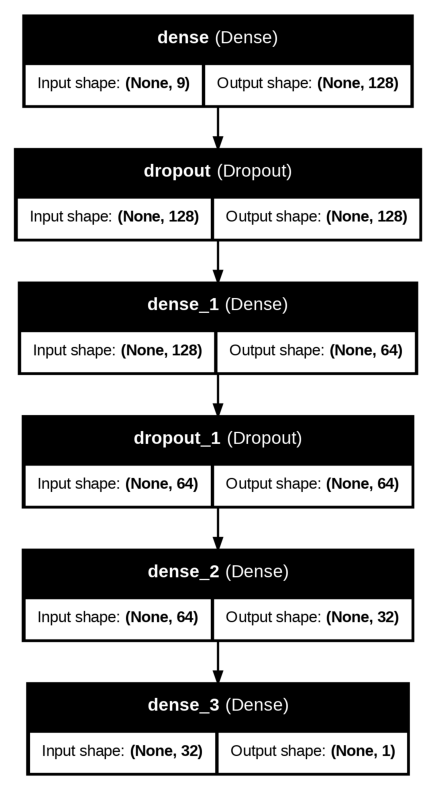

In [20]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Guardar y mostrar el gráfico del modelo
plot_model(model, to_file="modelo_red.png", show_shapes=True, show_layer_names=True)

# Mostrar la imagen directamente en Colab
img = mpimg.imread("modelo_red.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

 ## **<font color="DeepPink">Compilar el modelo</font>**

En esta etapa se compila el modelo. Es el paso final de configuración antes de que el modelo pueda ser entrenado.

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

<p align="justify">
Para compilar se debe definir un optimizador y la métrica de error. El ADAM (Adaptive Moment Estimation) es uno de los algoritmos de optimización más utilizados y efectivos en el aprendizaje profundo. La tasa de aprendizaje (<code>learning rate</code>)  es quizás el parámetro más importante del optimizador,  este parámetro controla el tamaño de los "pasos" que da el optimizador para ajustar los pesos.
<br><br>
Por último función de pérdida (<code>loss</code>) es la métrica que cuantifica el error de las predicciones del modelo en comparación con los valores reales. El objetivo del optimizador es minimizar el valor de esta función. Se usa mse, abreviatura de Mean Squared Error (Error Cuadrático Medio). Esta es la función de pérdida estándar para problemas de regresión (predecir un valor numérico continuo), como lo es el precio de la opción (<code>lastPrice</code>).

## **<font color="DeepPink">Entrenar el modelo (con early stopping)</font>**

<p align="justify">
<code>EarlyStopping</code> es un callback que que funciona como un criterio de detención temprana que interrumpe el proceso de entrenamiento iterativo cuando una métrica de rendimiento específica, monitoreada sobre un conjunto de datos de validación, deja de mejorar. Al evaluar el desempeño del modelo al final de cada época, esta técnica identifica el punto óptimo de entrenamiento en el que la capacidad de generalización del modelo es máxima, evitando así las iteraciones adicionales que conducirían al sobreajuste.

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',                                                         # Métrica a observar
    patience=15,                                                                # Épocas a esperar sin mejora antes de detener
    restore_best_weights=True                                                   # Restaura los pesos del modelo de la mejor época
)

<p align="justify">
El parámetro <code>monitor</code> indica qué métrica vigilar, <code>val_loss</code>significa que observará la función de pérdida en el conjunto de datos de validación. El siguiente parámetro, <code>patience=15</code> significa que, si pasan 15 épocas completas sin ninguna mejora, el entrenamiento se detiene.
<br><br>
<code>restore_best_weights=True</code>, te aseguras de que una vez que el entrenamiento se detenga, el modelo descarte los pesos de las últimas épocas y restaure los que lograron el mejor val_loss durante todo el entrenamiento. Esto garantiza que te quedes con la mejor versión posible de tu modelo.
<br><br>
Este objeto creado <code>early_stopping</code> luego se pasa a <code>model.fit()</code> para que se active durante el entrenamiento:

In [23]:
print("\nIniciando entrenamiento del modelo...")
history = model.fit(
    X_train, y_train,
    epochs=200,                                                                 # Número máximo de épocas
    batch_size=32,
    verbose=1,                                                                  # Muestra el progreso
    validation_split=0.2,
    callbacks=[early_stopping]                                                  # Aplicar el callback
)
print("Entrenamiento finalizado.")


Iniciando entrenamiento del modelo...
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 67.2571 - val_loss: 87.0218
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 59.3210 - val_loss: 76.7700
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 52.8755 - val_loss: 66.1343
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 48.0235 - val_loss: 55.2888
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 43.0268 - val_loss: 44.5701
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 33.1616 - val_loss: 34.3765
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 27.5841 - val_loss: 25.5633
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 22.5680 - val_loss: 18.8531
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 19.8497 - val_loss: 14.8271
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.9189 - val_loss: 13.2679
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 10.7324 - val_loss: 13.0624
Epoch 12/200


<p align="justify">
Una época es una pasada completa a través de todo el conjunto de datos de entrenamiento. <code>epochs=200</code> le estás diciendo al modelo que revise todos los datos un máximo de 200 veces.
<br><br>
El modelo no procesa todos los datos de una sola vez. Lo hace en pequeños lotes o "batches". <code>batch_size=32</code> significa que el modelo tomará 32 filas de datos, hará sus predicciones, calculará el error y ajustará sus pesos. Luego, tomará las siguientes 32 filas y repetirá el proceso, hasta terminar la época.
<br><br>
Antes de empezar a entrenar, Keras automáticamente apartará el 20 % de tus datos de X_train y y_train para usarlos como un conjunto de validación. El modelo no aprende de estos datos; solo los usa al final de cada época para evaluar su rendimiento en información que no ha visto. La métrica val_loss que monitorea tu EarlyStopping se calcula sobre este conjunto.
<br><br>
En <code>callbacks=[early_stopping]</code> es donde se activan las reglas antes definidas. Se activando la regla de EarlyStopping para que supervise el <code>val_loss</code> y detenga el entrenamiento si es necesario.

## **<font color="DeepPink">Evaluar el modelo</font>**

 <p align="justify">
 Por último, se evalúa el rendimiento del modelo utilizando datos que nunca antes ha visto (<code>X_test</code>) y se cuantifica qué tan buenas fueron sus predicciones.

In [24]:
y_pred = model.predict(X_test).flatten()

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
epsilon = 1e-10                                                                 # Se añade una pequeña cantidad (epsilon) para evitar la división por cero en MAPE
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
r2 = r2_score(y_test, y_pred)

print("\nMétricas de rendimiento del modelo:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f} %")
print(f"R²: {r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Métricas de rendimiento del modelo:
MSE: 6.9208
RMSE: 2.6308
MAE: 1.9220
MAPE: 244.60 %
R²: 0.7428
